In [87]:
### Librairie à installer dans l'environnement conda (si on exécute en local)
# qui sera choisi pour exécuter le carnet
from SPARQLWrapper import SPARQLWrapper, JSON, TURTLE, XML, RDFXML
import pandas as pd


import networkx as nx
from networkx.algorithms import bipartite

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import math
import os

In [88]:
### Librairies déjà installées avec Python
import pprint
import csv

import sqlite3 as sql

import time
import datetime
from dateutil import parser


from shutil import copyfile

In [89]:
### Importer un module de fonctions crées ad hoc
##  ATTENTION : le fichier 'sparql_functions.py' doit se trouver 
#   dans un dossier qui se situe dans le chemin ('path') de recherche
#   vu par le présent carnet Jupyter afin que
#   l'importation fonctionne correctement

import sys
from importlib import reload

# Add parent directory to the path
sys.path.insert(0, '..')

### If you want to add the parent-parent directory,
sys.path.insert(0, '../..')


import sparql_functions as spqf
import network_analysis_functions as naf

In [90]:
print(reload(naf))  

<module 'network_analysis_functions' from '/home/My_notebook_printemps/network_analysis_functions.py'>


In [91]:
## Définir le endpoint SPARQL
endpoint = "https://ag1khc5dnlqgdc0c.allegrograph.cloud/repositories/Astronauts"

In [92]:
# Requête SPARQL pour récupérer les données des universités
query = """
PREFIX wd: <http://www.wikidata.org/entity/>
PREFIX wdt: <http://www.wikidata.org/prop/direct/>
PREFIX wikibase: <http://wikiba.se/ontology#>
PREFIX bd: <http://www.bigdata.com/rdf#>
PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>

SELECT DISTINCT ?item ?itemLabel ?gender ?year ?education ?educationLabel
WHERE {
    SERVICE <https://query.wikidata.org/sparql> {    
        {
            ?item wdt:P106 wd:Q11631  # Astronaute
        } UNION {
            ?item wdt:P101 wd:Q22719  # Astronautics
        } UNION {
            ?item wdt:P106 wd:Q765633  # Aviation
        }
          
        ?item wdt:P31 wd:Q5;  # Any instance of a human
            wdt:P569 ?birthDate;
            wdt:P21 ?gender.
            
        # Ajout des informations sur l'éducation
        OPTIONAL {
            ?item wdt:P69 ?education.
            ?education rdfs:label ?educationLabel.
            FILTER(LANG(?educationLabel) = "en")
        }
        
        BIND(REPLACE(str(?birthDate), "(.*)([0-9]{4})(.*)", "$2") AS ?year)
        FILTER(xsd:integer(?year) > 1900 && xsd:integer(?year) < 2025)
        
        SERVICE wikibase:label { 
            bd:serviceParam wikibase:language "en" 
        }
    }
}

"""

In [93]:
sparql = SPARQLWrapper(endpoint)
sparql.setQuery(query)
sparql.setReturnFormat(JSON)
results = sparql.query().convert()




In [94]:
# Extraire toutes les valeurs d'educationLabel
educations = []
for result in results["results"]["bindings"]:
    edu_label = result.get("educationLabel", {}).get("value")
    if edu_label:
        educations.append(edu_label)

In [95]:

print(f"Nombre total d'écoles/éducations distinctes : {len(set(educations))}")

from collections import Counter
counter = Counter(educations)

print("Top 10 des lieux de formation les plus fréquents parmi les astronautes :")
for edu, count in counter.most_common(10):
    print(f"{edu}: {count}")

Nombre total d'écoles/éducations distinctes : 886
Top 10 des lieux de formation les plus fréquents parmi les astronautes :
U.S. Air Force Test Pilot School: 95
United States Naval Test Pilot School: 81
United States Naval Academy: 59
Massachusetts Institute of Technology: 48
United States Air Force Academy: 44
Naval Postgraduate School: 40
Moscow Aviation Institute: 30
Stanford University: 28
Purdue University: 25
Gagarin Air Force Academy: 24


In [96]:
# Exploration du contenu brut pour comprendre ce qui est retourné
for result in results["results"]["bindings"]:
    print(result)
    break  # Enlève ce break si tu veux tout voir

{'item': {'type': 'uri', 'value': 'http://www.wikidata.org/entity/Q448320'}, 'gender': {'type': 'uri', 'value': 'http://www.wikidata.org/entity/Q6581097'}, 'year': {'type': 'literal', 'value': '1970'}, 'education': {'type': 'uri', 'value': 'http://www.wikidata.org/entity/Q35794'}, 'educationLabel': {'type': 'literal', 'value': 'University of Cambridge'}}


In [97]:
# Exécuter la requête SPARQL
sparql = SPARQLWrapper(endpoint)
sparql.setQuery(query)
sparql.setReturnFormat(JSON)
results = sparql.query().convert()

In [115]:

# Extraire les liens astronautes -> éducation
edges = []
for res in results["results"]["bindings"]:
    astronaut = res.get("itemLabel", {}).get("value")
    education = res.get("educationLabel", {}).get("value")
    if astronaut and education:
        edges.append((astronaut, education))

In [116]:
import networkx as nx
import matplotlib.pyplot as plt

In [117]:
dges = []

for res in results["results"]["bindings"]:
    astronaut_uri = res.get("item", {}).get("value")  # ex: 'http://www.wikidata.org/entity/Q448320'
    education_label = res.get("educationLabel", {}).get("value")
    if astronaut_uri and education_label:
        astronaut_id = astronaut_uri.split('/')[-1]  # extraire 'Q448320'
        edges.append((astronaut_id, education_label))

In [118]:
print(f"Nombre de relations astronaute ↔ éducation : {len(edges)}")

Nombre de relations astronaute ↔ éducation : 1950


In [102]:
G = nx.Graph()
G.add_edges_from(edges)

Community 1 (size=139): {'Q535234', 'Q348205', 'Q345658', 'Q12040315', 'Borisoglebsk Higher Aviators School', 'Q467732', 'Q12865', 'Q708689', 'Q722142', 'Lyubertsy technical school', 'Q360060', 'Q314921', 'Q431006', 'Polish Air Force University', 'Q434546', 'Q382184', 'Q451259', 'Q353687', 'Q455669', 'Q70853', 'Stavropol Higher Military Aviation School of Pilots and Navigators PVO', 'Q152298', 'Q465748', 'Bryansk State Technical University', 'Central Institute for Earth Physics', 'Azerbaijan State Oil and Industrial University', 'Franz Mehring Military Academy', 'Kremenchuk flight college of National Aviation University', 'Q362180', 'Q709634', 'Q448491', 'Q535280', 'V. I. Lenin Military-Political Academy', 'Q538639', 'Q465724', 'Tambov Higher Military Aviation Engineering School', 'Q711010', 'Q7327', 'Saint Petersburg Suvorov Military School', 'Q641389', 'Q450834', 'Q446531', 'Q457064', 'Q487984', 'Penza State University', 'Q44371', 'Q152318', 'Q448538', 'Q104865', 'Q10340525', 'Tashke

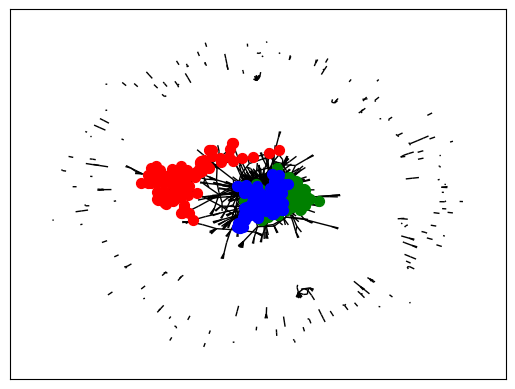

In [103]:
import networkx as nx
import matplotlib.pyplot as plt

# Calcul des communautés Louvain
communities = nx.community.louvain_communities(G)

# Trier les communautés par taille décroissante
communities_sorted = sorted(communities, key=len, reverse=True)

# Par exemple, garder les 3 plus grandes communautés
top_n = 3
top_communities = communities_sorted[:top_n]

# Afficher les communautés importantes
for i, community_nodes in enumerate(top_communities):
    print(f"Community {i+1} (size={len(community_nodes)}): {community_nodes}")

# Dessiner le graphe avec uniquement ces communautés
pos = nx.spring_layout(G)
colors = ["r", "g", "b", "y", "c", "m"]  # Couleurs supplémentaires au cas où

for i, community_nodes in enumerate(top_communities):
    nx.draw_networkx_nodes(G, pos,
                           nodelist=community_nodes,
                           node_color=colors[i % len(colors)],
                           node_size=50)

# Dessiner les arêtes uniquement entre ces nœuds
# Option 1 : dessiner toutes les arêtes (mais ça peut inclure celles hors communautés)
nx.draw_networkx_edges(G, pos)

plt.show()


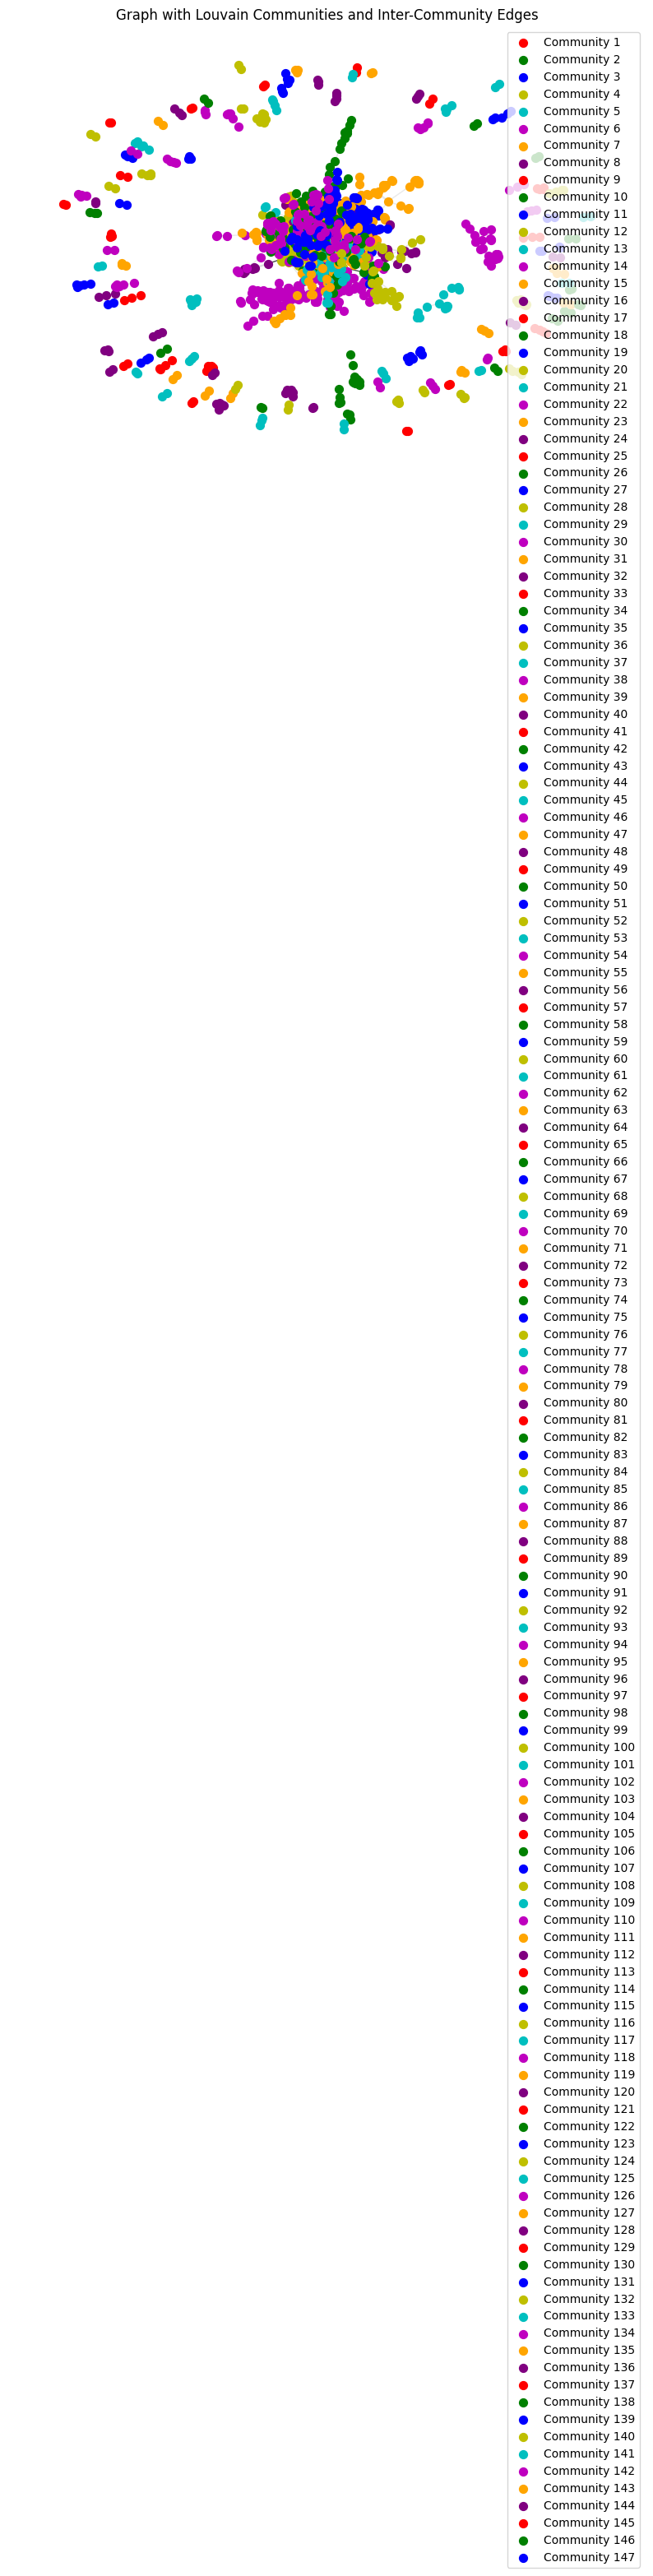

In [104]:
import networkx as nx
import matplotlib.pyplot as plt

# Suppose que G est ton graphe construit avant

# Calculer les communautés Louvain
communities = nx.community.louvain_communities(G)
communities = list(communities)  # convert to list for indexing

# Préparer un dict nœud -> communauté_id
node_to_community = {}
for i, comm in enumerate(communities):
    for node in comm:
        node_to_community[node] = i

pos = nx.spring_layout(G, seed=42)  # Position fixe pour stabilité

colors = ["r", "g", "b", "y", "c", "m", "orange", "purple"]

plt.figure(figsize=(10, 7))

# Dessiner les nœuds par communauté
for i, community_nodes in enumerate(communities):
    nx.draw_networkx_nodes(G, pos,
                           nodelist=community_nodes,
                           node_color=colors[i % len(colors)],
                           node_size=50,
                           label=f"Community {i+1}")

# Séparer les arêtes internes et externes
internal_edges = []
external_edges = []

for u, v in G.edges():
    if node_to_community.get(u) == node_to_community.get(v):
        internal_edges.append((u, v))
    else:
        external_edges.append((u, v))

# Dessiner les arêtes internes (dans la même communauté) en gris clair
nx.draw_networkx_edges(G, pos, edgelist=internal_edges, edge_color='lightgray', alpha=0.5)

# Dessiner les arêtes externes (entre communautés) en noir plus visible
nx.draw_networkx_edges(G, pos, edgelist=external_edges, edge_color='black', alpha=0.7)

plt.legend()
plt.axis('off')
plt.title("Graph with Louvain Communities and Inter-Community Edges")
plt.show()


/tmp/ipykernel_144/593490603.py:34: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab20', len(top_communities))


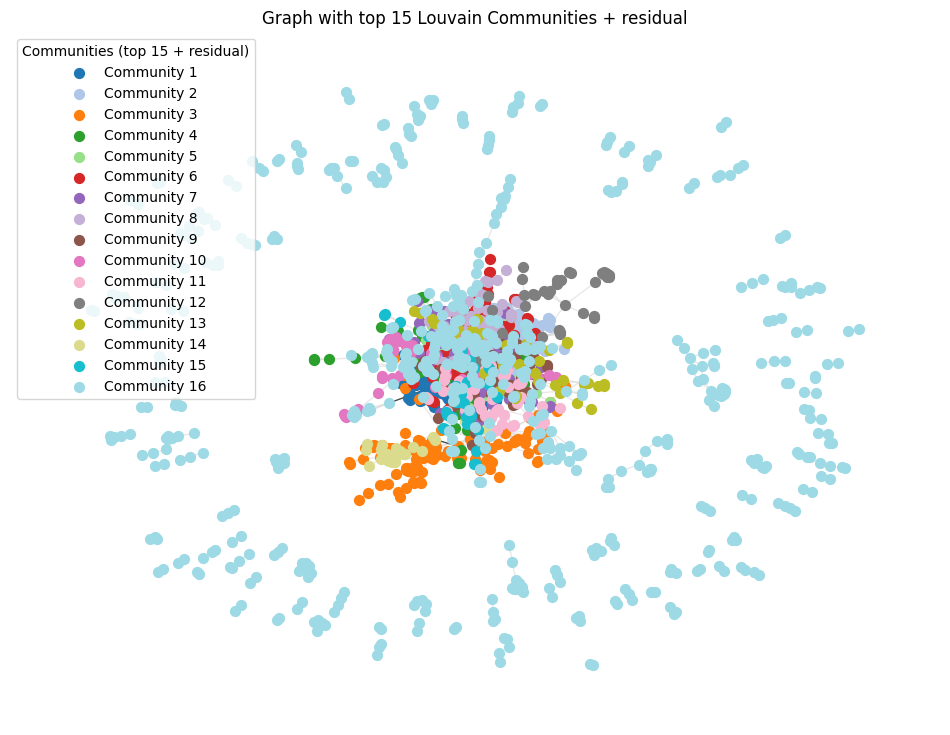

In [105]:
import networkx as nx
import matplotlib.pyplot as plt

# Ton graphe G déjà construit

# Louvain communities (beaucoup de petites)
communities = list(nx.community.louvain_communities(G))

# Trier par taille décroissante
communities = sorted(communities, key=len, reverse=True)

# Nombre max de communautés affichées
max_communities = 15

# Prendre les 15 plus grandes
top_communities = communities[:max_communities]

# Fusionner les petites restantes dans une communauté résiduelle
residual_nodes = set()
for comm in communities[max_communities:]:
    residual_nodes.update(comm)
if residual_nodes:
    top_communities.append(residual_nodes)

# Construire dict node -> communauté_id
node_to_community = {}
for i, comm in enumerate(top_communities):
    for node in comm:
        node_to_community[node] = i

pos = nx.spring_layout(G, seed=42)

# Palette couleurs étendue
colors = plt.cm.get_cmap('tab20', len(top_communities))

plt.figure(figsize=(12, 9))

# Dessiner les noeuds par communauté
for i, community_nodes in enumerate(top_communities):
    nx.draw_networkx_nodes(G, pos,
                           nodelist=community_nodes,
                           node_color=[colors(i)],
                           node_size=50,
                           label=f"Community {i+1}")

# Séparer les arêtes internes et externes
internal_edges = []
external_edges = []

for u, v in G.edges():
    if node_to_community.get(u) == node_to_community.get(v):
        internal_edges.append((u, v))
    else:
        external_edges.append((u, v))

# Arêtes internes en gris clair
nx.draw_networkx_edges(G, pos, edgelist=internal_edges, edge_color='lightgray', alpha=0.5)

# Arêtes externes en noir
nx.draw_networkx_edges(G, pos, edgelist=external_edges, edge_color='black', alpha=0.7)

plt.legend(title="Communities (top 15 + residual)")
plt.axis('off')
plt.title("Graph with top 15 Louvain Communities + residual")

plt.show()


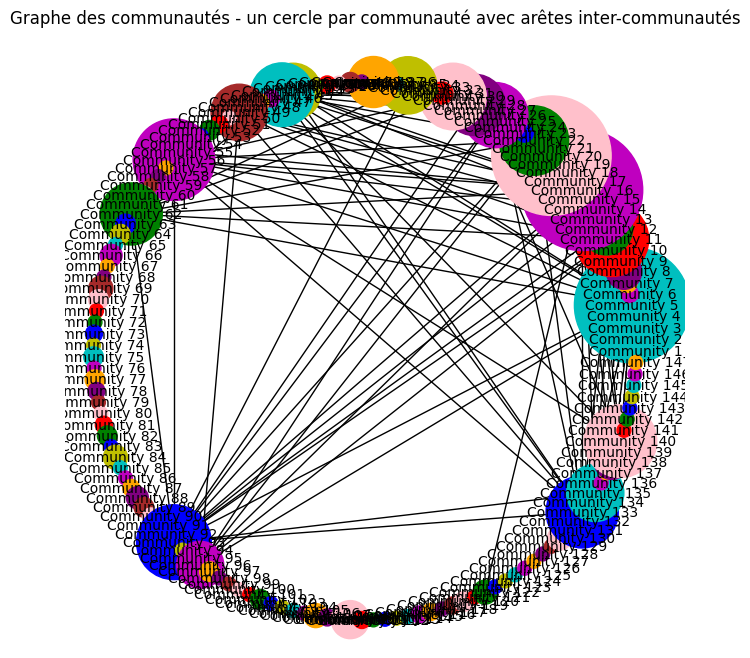

In [106]:
import networkx as nx
import matplotlib.pyplot as plt

# Supposons que G est ton graphe construit avant

# Calculer les communautés Louvain
communities = nx.community.louvain_communities(G)
communities = list(communities)  # convertir en liste pour l'indexation

# Construire un graphe des communautés (super-nœuds)
G_comm = nx.Graph()

# Ajouter un noeud par communauté avec l'attribut 'size' = taille de la communauté
for i, comm in enumerate(communities):
    G_comm.add_node(i, size=len(comm))

# Construire un dictionnaire nœud -> communauté
node_to_community = {}
for i, comm in enumerate(communities):
    for node in comm:
        node_to_community[node] = i

# Ajouter une arête entre communautés si au moins une arête entre leurs membres dans G
for u, v in G.edges():
    c_u = node_to_community[u]
    c_v = node_to_community[v]
    if c_u != c_v:
        G_comm.add_edge(c_u, c_v)

# Position des communautés en cercle
pos = nx.circular_layout(G_comm)

# Récupérer les tailles des communautés pour l'affichage (multipliées pour la visibilité)
sizes = [G_comm.nodes[n]['size'] * 50 for n in G_comm.nodes()]

# Couleurs pour les communautés
colors = ["r", "g", "b", "y", "c", "m", "orange", "purple", "brown", "pink"]

plt.figure(figsize=(8, 8))

# Dessiner les nœuds communautés avec taille proportionnelle
nx.draw_networkx_nodes(G_comm, pos,
                       node_size=sizes,
                       node_color=[colors[i % len(colors)] for i in G_comm.nodes()])

# Dessiner les arêtes entre communautés
nx.draw_networkx_edges(G_comm, pos)

# Ajouter labels simples : Community 1, Community 2, ...
labels = {n: f"Community {n+1}" for n in G_comm.nodes()}
nx.draw_networkx_labels(G_comm, pos, labels, font_size=10)

plt.title("Graphe des communautés - un cercle par communauté avec arêtes inter-communautés")
plt.axis('off')
plt.show()


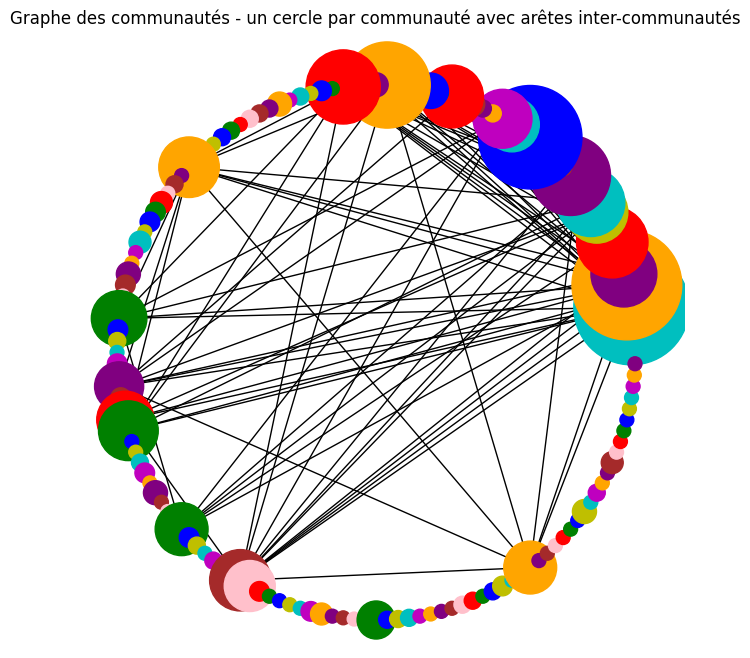

In [107]:
import networkx as nx
import matplotlib.pyplot as plt

# Supposons que G est ton graphe construit avant

# Calculer les communautés Louvain
communities = nx.community.louvain_communities(G)
communities = list(communities)  # convertir en liste pour l'indexation

# Construire un graphe des communautés (super-nœuds)
G_comm = nx.Graph()

# Ajouter un noeud par communauté avec l'attribut 'size' = taille de la communauté
for i, comm in enumerate(communities):
    G_comm.add_node(i, size=len(comm))

# Construire un dictionnaire nœud -> communauté
node_to_community = {}
for i, comm in enumerate(communities):
    for node in comm:
        node_to_community[node] = i

# Ajouter une arête entre communautés si au moins une arête entre leurs membres dans G
for u, v in G.edges():
    c_u = node_to_community[u]
    c_v = node_to_community[v]
    if c_u != c_v:
        G_comm.add_edge(c_u, c_v)

# Position des communautés en cercle
pos = nx.circular_layout(G_comm)

# Récupérer les tailles des communautés pour l'affichage (multipliées pour la visibilité)
sizes = [G_comm.nodes[n]['size'] * 50 for n in G_comm.nodes()]

# Couleurs pour les communautés
colors = ["r", "g", "b", "y", "c", "m", "orange", "purple", "brown", "pink"]

plt.figure(figsize=(8, 8))

# Dessiner les nœuds communautés avec taille proportionnelle
nx.draw_networkx_nodes(G_comm, pos,
                       node_size=sizes,
                       node_color=[colors[i % len(colors)] for i in G_comm.nodes()])

# Dessiner les arêtes entre communautés
nx.draw_networkx_edges(G_comm, pos)

plt.title("Graphe des communautés - un cercle par communauté avec arêtes inter-communautés")
plt.axis('off')
plt.show()


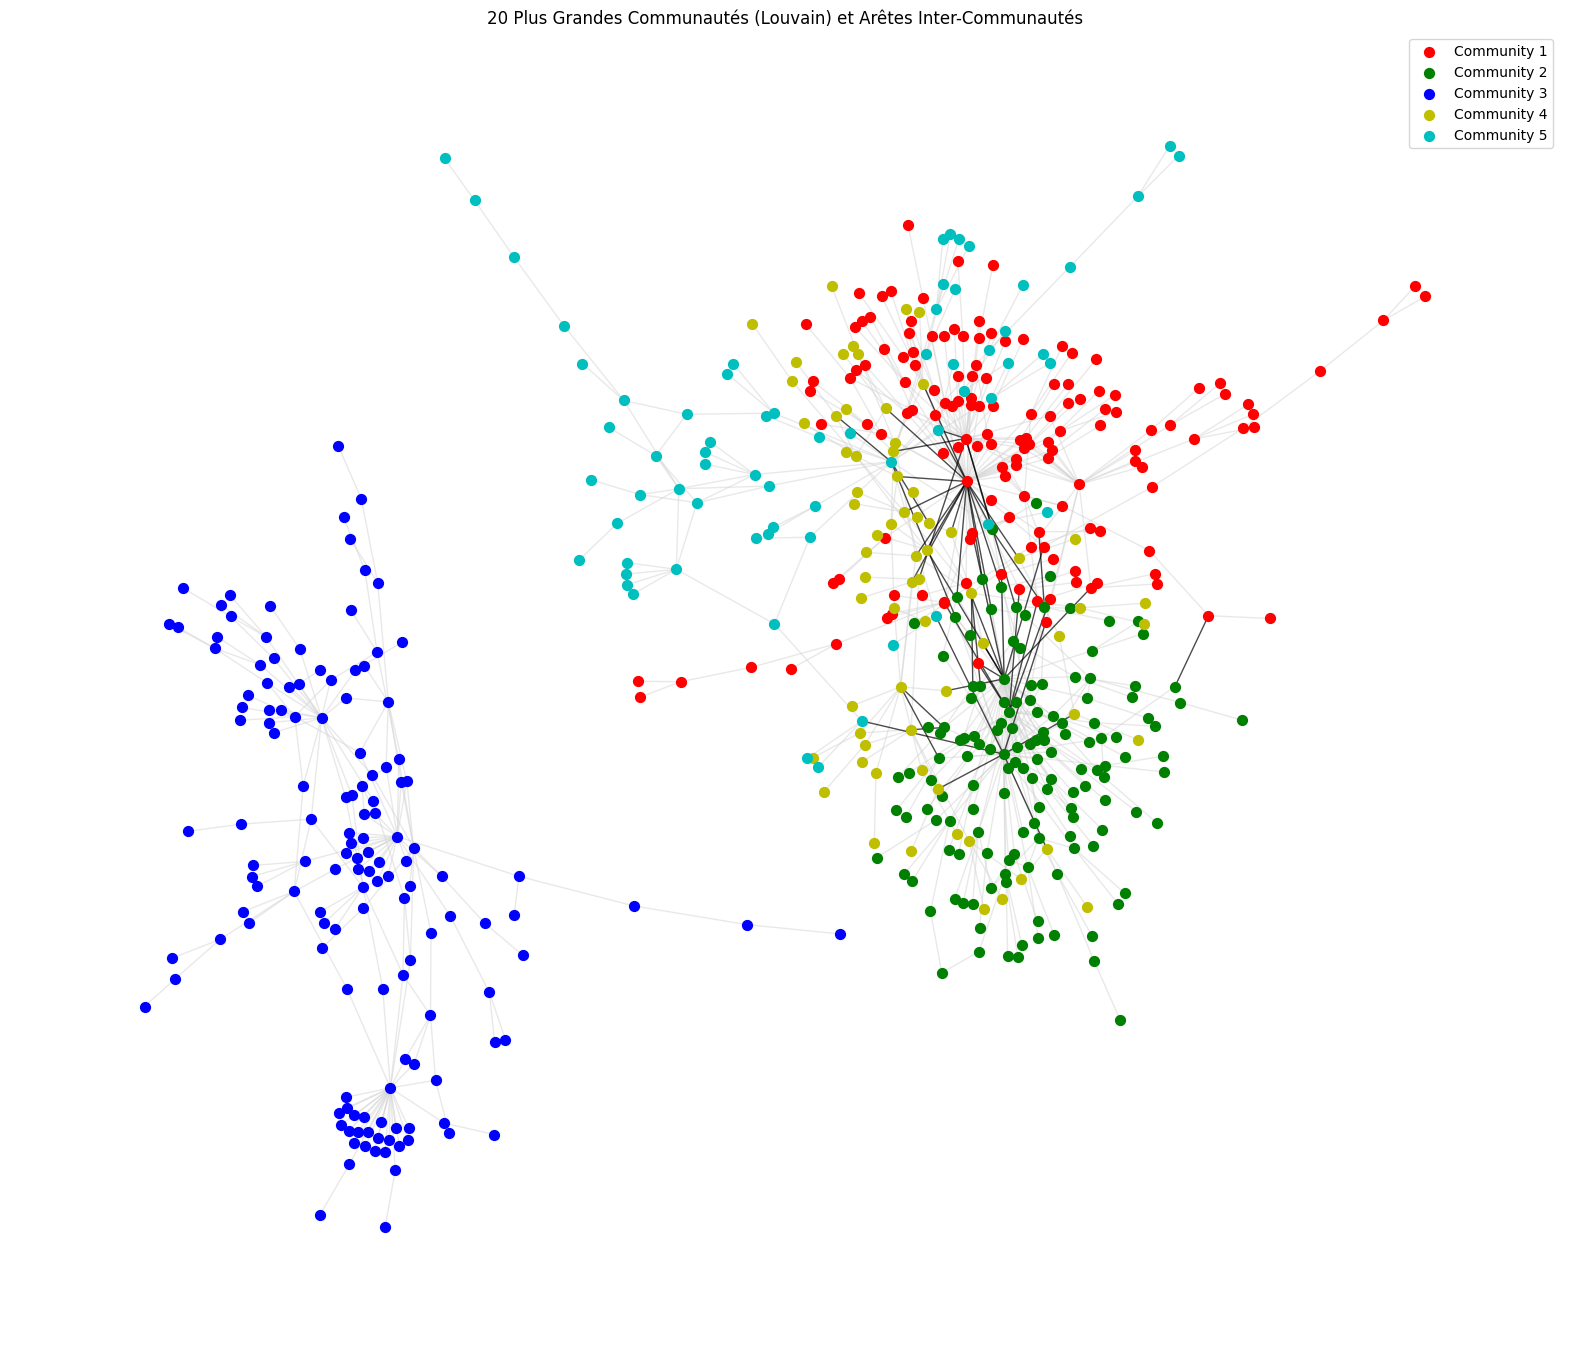

In [119]:
import networkx as nx
import matplotlib.pyplot as plt

# Suppose que G est ton graphe construit avant

# Calculer les communautés Louvain
communities = nx.community.louvain_communities(G)
communities = list(communities)

# Trier les communautés par taille décroissante et garder les 20 plus grandes
communities = sorted(communities, key=len, reverse=True)[:5]

# Préparer un dict nœud -> communauté_id
node_to_community = {}
for i, comm in enumerate(communities):
    for node in comm:
        node_to_community[node] = i

# Sous-graphe contenant seulement les nœuds des 20 plus grandes communautés
nodes_in_top_communities = set(node_to_community.keys())
G_sub = G.subgraph(nodes_in_top_communities)

# Calculer la disposition des nœuds
pos = nx.spring_layout(G_sub, seed=50)
# Palette de couleurs
colors = ["r", "g", "b", "y", "c", "m", "orange", "purple", "pink", "brown", 
          "teal", "lime", "indigo", "gold", "navy", "coral", "salmon", "olive", "cyan", "maroon"]

plt.figure(figsize=(20, 17))

# Dessiner les nœuds par communauté
for i, community_nodes in enumerate(communities):
    nx.draw_networkx_nodes(G_sub, pos,
                           nodelist=list(community_nodes),
                           node_color=colors[i % len(colors)],
                           node_size=50,
                           label=f"Community {i+1}")

# Séparer les arêtes internes et externes
internal_edges = []
external_edges = []

for u, v in G_sub.edges():
    if node_to_community.get(u) == node_to_community.get(v):
        internal_edges.append((u, v))
    else:
        external_edges.append((u, v))

# Dessiner les arêtes
nx.draw_networkx_edges(G_sub, pos, edgelist=internal_edges, edge_color='lightgray', alpha=0.5)
nx.draw_networkx_edges(G_sub, pos, edgelist=external_edges, edge_color='black', alpha=0.7)

plt.legend()
plt.axis('off')
plt.title("20 Plus Grandes Communautés (Louvain) et Arêtes Inter-Communautés")
plt.show()


In [120]:
for i, comm in enumerate(communities):
    print(f"Communauté {i+1} ({len(comm)} nœuds) :")
    print(comm)
    print()

Communauté 1 (145 nœuds) :
{'U.S. Air Force Test Pilot School', 'Q130909094', 'Q3476196', 'Q3376613', 'Q573473', 'Q682970', 'Fairborn High School', 'Q1174171', 'Q1407313', 'Woodmore High School', 'Q363976', 'Bedford North Lawrence High School', 'University of Maine', 'Q1371289', 'Oakland Community College', 'Temple City High School', 'Q720182', 'Baldwin Wallace University', 'Q345678', 'Salina High School Central', 'Lake Orion High School', 'Clements High School', 'Centaurus High School', 'Q3157177', 'Q312833', 'Blue Hills Regional Technical School', 'University of Massachusetts Dartmouth', 'Chamblee High School', 'West Monroe High School', 'Q505530', 'Q1338950', 'Jackson College', 'University of Delaware', 'Amityville Memorial High School', 'Q158486', 'Kalamazoo Central High School', 'Ross School of Business', 'Q313543', 'Wichita East High School', 'United States Air Force Academy', 'Q1494855', 'Q974431', 'Q746108', 'Q1376909', 'Dalhousie University', "Queen's University", 'Wiesbaden H

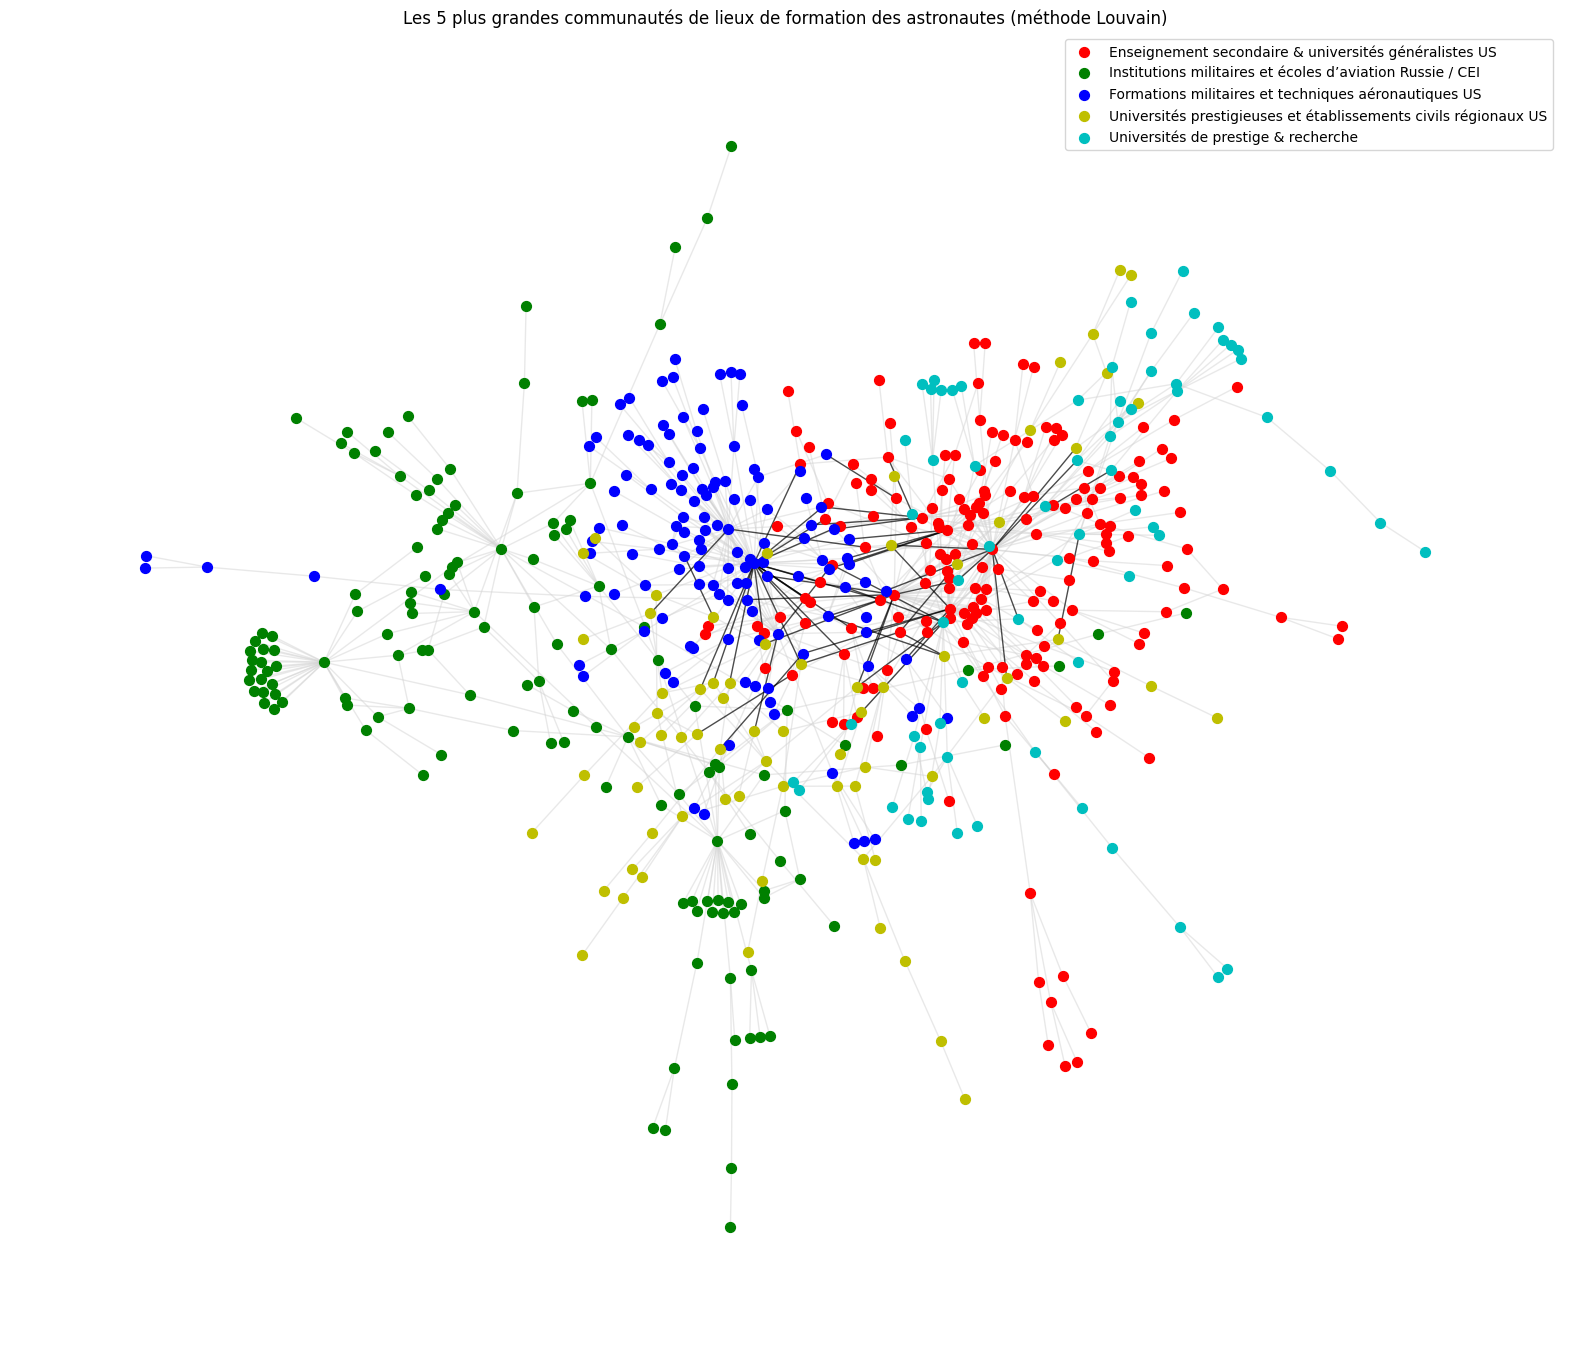

In [130]:
import networkx as nx
import matplotlib.pyplot as plt

# Suppose que G est ton graphe construit avant

# Calculer les communautés Louvain
communities = nx.community.louvain_communities(G)
communities = list(communities)

# Trier les communautés par taille décroissante et garder les 5 plus grandes
communities = sorted(communities, key=len, reverse=True)[:5]

# Noms personnalisés pour les communautés
community_names = [
    "Enseignement secondaire & universités généralistes US",
    "Institutions militaires et écoles d’aviation Russie / CEI",
    "Formations militaires et techniques aéronautiques US",
    "Universités prestigieuses et établissements civils régionaux US",
    "Universités de prestige & recherche"
]

# Préparer un dict nœud -> communauté_id
node_to_community = {}
for i, comm in enumerate(communities):
    for node in comm:
        node_to_community[node] = i

# Sous-graphe contenant seulement les nœuds des 5 plus grandes communautés
nodes_in_top_communities = set(node_to_community.keys())
G_sub = G.subgraph(nodes_in_top_communities)

# Calculer la disposition des nœuds
pos = nx.spring_layout(G_sub, seed=42)

# Palette de couleurs (tu peux la modifier si tu veux)
colors = ["r", "g", "b", "y", "c"]

plt.figure(figsize=(20, 17))

# Dessiner les nœuds par communauté avec les noms personnalisés
for i, community_nodes in enumerate(communities):
    nx.draw_networkx_nodes(G_sub, pos,
                           nodelist=list(community_nodes),
                           node_color=colors[i % len(colors)],
                           node_size=50,
                           label=community_names[i])

# Séparer les arêtes internes et externes
internal_edges = []
external_edges = []

for u, v in G_sub.edges():
    if node_to_community.get(u) == node_to_community.get(v):
        internal_edges.append((u, v))
    else:
        external_edges.append((u, v))

# Dessiner les arêtes
nx.draw_networkx_edges(G_sub, pos, edgelist=internal_edges, edge_color='lightgray', alpha=0.5)
nx.draw_networkx_edges(G_sub, pos, edgelist=external_edges, edge_color='black', alpha=0.7)

plt.legend()
plt.axis('off')
plt.title("Les 5 plus grandes communautés de lieux de formation des astronautes (méthode Louvain)")
plt.show()


In [128]:
for i, comm in enumerate(communities):
    print(f"Communauté {i+1} ({len(comm)} nœuds) :")
    print(comm)
    print()

Communauté 1 (170 nœuds) :
{'University of Wisconsin–River Falls', 'Q692263', 'Q120793', 'Q1345924', 'University of Idaho', 'Q260329', 'Q363976', 'Q17519', 'Richland High School', 'Q2036770', 'Q2036753', 'Arthur L. Johnson High School', 'Georgia Tech', 'Q709921', 'Q706939', 'Q1429300', 'Baldwin Wallace University', 'Q345678', 'College of William & Mary', 'Q362190', 'Ballard High School', 'University of Bath', 'George Mason University', 'Coronado High School', 'Northeast High School', 'University of Bristol', 'University of Colorado, at Colorado Springs', 'Q4934240', 'Dwight Morrow High School', 'Q1064149', 'State University of New York', 'Southern High School', 'Q985049', 'Ashland High School', 'The Citadel', 'Q30157819', 'Q110916469', 'T.L. Hanna High School', 'Q334463', 'United States Merchant Marine Academy', "D'Evelyn Junior/Senior High School", 'Pine-Richland High School', 'Q109968497', 'Q718729', 'United States Naval Academy', 'New Jersey Institute of Technology', 'John F. Kenned

In [131]:
import networkx as nx
from collections import defaultdict

# On suppose que tu as déjà ces variables :
# - G_sub : sous-graphe contenant les nœuds des 5 plus grandes communautés
# - node_to_community : dictionnaire nœud -> communauté_id

# Initialiser un dictionnaire pour compter les liens entre communautés
external_links_count = defaultdict(int)

for u, v in G_sub.edges():
    comm_u = node_to_community.get(u)
    comm_v = node_to_community.get(v)
    if comm_u is not None and comm_v is not None and comm_u != comm_v:
        # On trie les communautés pour éviter les doublons (comm_a, comm_b) == (comm_b, comm_a)
        key = tuple(sorted((comm_u, comm_v)))
        external_links_count[key] += 1

# Afficher les résultats
print("Nombre de liens externes entre communautés :")
for (comm_a, comm_b), count in external_links_count.items():
    print(f"Entre '{community_names[comm_a]}' et '{community_names[comm_b]}': {count} liens")


Nombre de liens externes entre communautés :
Entre 'Enseignement secondaire & universités généralistes US' et 'Formations militaires et techniques aéronautiques US': 29 liens
Entre 'Enseignement secondaire & universités généralistes US' et 'Universités prestigieuses et établissements civils régionaux US': 10 liens
Entre 'Formations militaires et techniques aéronautiques US' et 'Universités prestigieuses et établissements civils régionaux US': 10 liens
Entre 'Enseignement secondaire & universités généralistes US' et 'Universités de prestige & recherche': 6 liens
Entre 'Universités prestigieuses et établissements civils régionaux US' et 'Universités de prestige & recherche': 3 liens
Entre 'Formations militaires et techniques aéronautiques US' et 'Universités de prestige & recherche': 2 liens
